In [1]:
# DEFINE WHAT TO TRAIN WITH (and KFOLD VALIDATE) VERSUS HOLDOUT VALIDATE WITH
# ADD WORDS "kaggle.csv", "jin_tm.csv", "jin_train.csv", "jin_test.csv" to lists below
# IF YOU ADD MORE DATASETS, ADD THOSE WORDS TOO

KFOLD_SOURCES = ['jin_tm.csv','jin_train.csv','jin_test.csv']
HOLDOUT_SOURCES = ['kaggle.csv']

# IF WILD TYPE GROUP HAS FEWER THAN THIS MANY MUTATION ROWS REMOVE THEM
EXCLUDE_CT_UNDER = 25

# IF WE TRAIN WITH ALPHA FOLD'S PDBS WE MUST INFER WITH "PLDDT = TRUE"
# KAGGLE.CSV USES ALPHA FOLD PDB, SO SET BELOW TO TRUE WHEN TRAIN WITH KAGGLE.CSV
# JIN.CSV EXTERNAL DATA USES PROTEIN DATA BANK, SO SET BELOW TO FALSE WITH JIN DATA
USE_PLDDT_INFER = False

# IF WE WISH TO TRAIN WITH MIXTURE OF ALPHA FOLD AND PROTEIN DATA BANK PDB FILES
# THEN WE CAN EXCLUDE B_COLUMN AND THEN THERE IS NO PROBLEM
USE_B_COLUMN = False

VER = 17

In [2]:
import os, numpy as np, gc, seaborn as sns
from scipy.stats import spearmanr, pearsonr, rankdata
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)

In [3]:
os.system('wget https://raw.githubusercontent.com/JinyuanSun/mutation-stability-data/main/train.csv')
os.system('wget https://raw.githubusercontent.com/JinyuanSun/mutation-stability-data/main/test.csv')
os.system('wget https://raw.githubusercontent.com/JinyuanSun/mutation-stability-data/main/tm.csv')
os.system('mkdir downloaded_csv; mv *csv downloaded_csv')

--2022-11-28 17:02:59--  https://raw.githubusercontent.com/JinyuanSun/mutation-stability-data/main/train.csv


256

In [4]:
df = pd.read_csv('./input/novozymes-xgboost/downloaded_csv/train.csv')
df = df.iloc[:,1:]
print('Downloaded train shape', df.shape )
df.head()

Downloaded train shape (3839, 7)


PDB wildtype  position mutation   ddG  \
0  1A5E        L       121        R  0.66   
1  1A5E        L        37        S  0.71   
2  1A5E        W        15        D  0.17   
3  1A5E        D        74        N -2.00   
4  1A5E        P        81        L  0.00   

                                            sequence  \
0  MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...   
1  MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...   
2  MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...   
3  MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...   
4  MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...   

                                          mutant_seq  
0  MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...  
1  MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGASPNAPNSYGR...  
2  MEPAAGSSMEPSADDLATAAARGRVEEVRALLEAGALPNAPNSYGR...  
3  MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...  
4  MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...

In [5]:
df2 = pd.read_csv('./input/novozymes-xgboost/downloaded_csv/test.csv')
df2 = df2.iloc[:,1:]
print('Downloaded test shape', df2.shape )
df2.head()

Downloaded test shape (259, 7)


PDB wildtype  position mutation       ddG  \
0  2PTL        L        24        A -2.939771   
1  2PTL        F        36        A -4.851816   
2  2PTL        A        51        G -3.274379   
3  2PTL        V        65        A -1.099426   
4  2PTL        I        74        V -0.167304   

                                            sequence  \
0  ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...   
1  ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...   
2  ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...   
3  ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...   
4  ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...   

                                          mutant_seq  
0  ENKEETPETPETDSEEEVTIKANAIFANGSTQTAEFKGTFEKATSE...  
1  ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEAKGTFEKATSE...  
2  ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...  
3  ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...  
4  ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...

In [6]:
df3 = pd.read_csv('./input/novozymes-xgboost/downloaded_csv/tm.csv')
df3 = df3.iloc[:,1:]
print('Downloaded tm shape', df3.shape )
df3.head()

Downloaded tm shape (998, 7)


PDB WT  position MUT  dTm  \
0  1CQW  V       245   L  2.1   
1  1CQW  L        95   V -0.4   
2  1CQW  C       176   F  5.2   
3  1CQW  G       171   Q  3.1   
4  1CQW  T       148   L  1.1   

                                            sequence  \
0  MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...   
1  MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...   
2  MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...   
3  MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...   
4  MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...   

                                          mutant_seq  
0  MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...  
1  MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...  
2  MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...  
3  MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...  
4  MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...

In [7]:
# https://www.kaggle.com/code/roberthatch/novo-train-data-contains-wildtype-groups/notebook
kaggle = pd.read_csv('./input/novozymes-xgboost/novo-train-data-contains-wildtype-groups/train_wildtype_groups.csv')
print('Before processing Robert dataframe shape:', kaggle.shape )
kaggle.head()

Before processing Robert dataframe shape: (4195, 8)


seq_id                                   protein_sequence   pH  \
0   18020  MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  2.0   
1   18021  MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  4.2   
2   18022  MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  2.0   
3   18023  MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  6.5   
4   18060  MNCFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  2.0   

           data_source    tm    x  group  \
0  10.1021/bi00535a054  38.1  164      0   
1                  NaN  53.3  164      0   
2     10.1038/334406a0  38.1  164      0   
3     10.1038/334406a0  62.9  164      0   
4                  NaN  41.9  164      0   

                                            wildtype  
0  MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
1  MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
2  MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
3  MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
4  MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...

In [8]:
kaggle['id'] = kaggle.data_source.astype('str') + '_' + kaggle.pH.astype('str') + '_' + kaggle.group.astype('str')
kaggle['ct'] = kaggle.groupby('id').id.transform('count')
kaggle['n'] = kaggle.groupby('id').tm.transform('nunique')
kaggle = kaggle.loc[kaggle.n>1]
kaggle = kaggle.sort_values(['group','ct'],ascending=[True,False])
KEEP = kaggle.groupby('group').id.agg('first').values
kaggle = kaggle.loc[kaggle.id.isin(KEEP)]

def find_mut(row):
    mut = row.protein_sequence
    seq = row.wildtype
    same = True
    for i,(x,y) in enumerate(zip(seq,mut)):
        if x!=y: 
            same = False
            break
    if not same:
        row['WT'] = seq[i]
        row['position'] = i+1
        row['MUT'] = mut[i]
    else:
        row['WT'] = 'X'
        row['position'] = -1   
        row['MUT'] = 'X'     
    return row

grp = [f'GP{g:02d}' for g in kaggle.group.values]
kaggle['PDB'] = grp
kaggle = kaggle.apply(find_mut,axis=1)
kaggle = kaggle.loc[kaggle.position!=-1]
kaggle['base'] = kaggle.groupby('group').tm.transform('mean')
kaggle['dTm'] = kaggle.tm - kaggle.base
kaggle = kaggle.rename({'wildtype':'sequence','protein_sequence':'mutant_seq'},axis=1)
COLS = ['PDB','WT','position','MUT','dTm','sequence','mutant_seq']
kaggle = kaggle[COLS]

# https://www.kaggle.com/datasets/shlomoron/train-wildtypes-af
alphafold = pd.read_csv('./input/novozymes-xgboost/train-wildtypes-af/alpha_fold_df.csv')
dd = {}
for s in kaggle.sequence.unique():
    tmp = alphafold.loc[alphafold.af2_sequence==s,'af2id']
    if len(tmp)>0: c = tmp.values[0].split(':')[1]
    else: c = np.nan
    dd[s] = c
    
kaggle['CIF'] = kaggle.sequence.map(dd)
kaggle = kaggle.loc[kaggle.CIF.notnull()].reset_index(drop=True)
kaggle.to_csv('kaggle_train.csv',index=False)
print('After processing Robert dataframe shape:', kaggle.shape )
kaggle.head()

After processing Robert dataframe shape: (1737, 8)


PDB WT  position MUT       dTm  \
0  GP01  T        95   C  1.297838   
1  GP01  T        95   C  0.097838   
2  GP01  T        95   S  2.297838   
3  GP01  T        95   S  3.697838   
4  GP01  T       104   C  2.397838   

                                            sequence  \
0  MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...   
1  MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...   
2  MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...   
3  MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...   
4  MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...   

                                          mutant_seq           CIF  
0  MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  AF-P00644-F1  
1  MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  AF-P00644-F1  
2  MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  AF-P00644-F1  
3  MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  AF-P00644-F1  
4  MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  AF-P00644-F1

In [9]:
df['source'] = 'jin_train.csv'
df['dTm'] = np.nan
df['CIF'] = None
df2['source'] = 'jin_test.csv'
df2['dTm'] = np.nan
df2['CIF'] = None

df3 = df3.loc[~df3.PDB.isin(['1RX4', '2LZM', '3MBP'])].copy()
df3['source'] = 'jin_tm.csv'
df3['ddG'] = np.nan
df3['CIF'] = None
df3 = df3.rename({'WT':'wildtype','MUT':'mutation'},axis=1)
df3 = df3[df.columns]

kaggle['source'] = 'kaggle.csv'
kaggle['ddG'] = np.nan
kaggle = kaggle.rename({'WT':'wildtype','MUT':'mutation'},axis=1)
kaggle = kaggle[df.columns]

df = pd.concat([df,df2,df3,kaggle],axis=0,ignore_index=True)
del df2, df3, kaggle
print('Combined data shape',df.shape)
df.to_csv(f'all_train_data_v{VER}.csv',index=False)
df = df.loc[df.source.isin(KFOLD_SOURCES+HOLDOUT_SOURCES)]
print('Kfold plus Holdout shape',df.shape)
df = df.sort_values(['PDB','position']).reset_index(drop=True)
df.head()

Combined data shape (6809, 10)
Kfold plus Holdout shape (6809, 10)


PDB wildtype  position mutation  ddG  \
0  1A43        G         9        A -1.0   
1  1A43        E        12        D -2.1   
2  1A43        R        20        A -3.0   
3  1A43        W        37        A -0.7   
4  1A43        C        71        S -2.3   

                                            sequence  \
0  TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...   
1  TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...   
2  TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...   
3  TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...   
4  TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...   

                                          mutant_seq         source  dTm   CIF  
0  TSILDIRQAPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...  jin_train.csv  NaN  None  
1  TSILDIRQGPKDPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...  jin_train.csv  NaN  None  
2  TSILDIRQGPKEPFRDYVDAFYKTLRAEQASQEVKNWMTETLLVQN...  jin_train.csv  NaN  None  
3  TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNAMTETLLVQN...  jin_train.csv  NaN  None  
4  TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...  jin_train.csv  NaN  None

In [10]:
print('There are',df.PDB.nunique(),'PDB files to download')

There are 290 PDB files to download


In [11]:
# THE FOLLOWING PROTEINS SEQUENCES CANNOT BE ALIGNED BETWEEN CSV AND PDB FILE (not sure why)
bad = [f for f in df.PDB.unique() if len(f)>4]
bad += ['1LVE', '2IMM', '2RPN', '1BKS', '1BLC', '1D5G', '1KDX', '1OTR', '3BN0', '3D3B', '3HHR', '3O39']
bad += ['3BDC','1AMQ','1X0J','1TPK','1GLM','1RHG','3DVI','1RN1','1QGV'] 
bad += ['1SVX','4E5K'] 
print(f'We will ignore mutations from {len(bad)} PDB files')

We will ignore mutations from 32 PDB files


In [12]:
!pip install py3Dmol -q
import py3Dmol 
with open("./input/novozymes-xgboost/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb") as ifile:
    protein = "".join([x for x in ifile])
#view = py3Dmol.view(query='pdb:1DIV', width=800, height=600)
view = py3Dmol.view(width=800, height=600) 
view.addModelsAsFrames(protein)
style = {'cartoon': {'color': 'spectrum'},'stick':{}}
view.setStyle({'model': -1},style) 
view.zoom(0.12)
view.rotate(235, {'x':0,'y':1,'z':1})
view.spin({'x':-0.2,'y':0.5,'z':1},1)
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [13]:
# BIOPANDAS PDB READER
!pip install biopandas -q
from biopandas.pdb import PandasPdb
from biopandas.mmcif import PandasMmcif
aa_map = {'VAL': 'V', 'PRO': 'P', 'ASN': 'N', 'GLU': 'E', 'ASP': 'D', 'ALA': 'A', 'THR': 'T', 'SER': 'S',
          'LEU': 'L', 'LYS': 'K', 'GLY': 'G', 'GLN': 'Q', 'ILE': 'I', 'PHE': 'F', 'CYS': 'C', 'TRP': 'W',
          'ARG': 'R', 'TYR': 'Y', 'HIS': 'H', 'MET': 'M'}
aa_map_2 = {x:y for x,y in zip(np.sort(list(aa_map.values())),np.arange(20))}
aa_map_2['X'] = 20

# https://www.kaggle.com/datasets/alejopaullier/aminoacids-physical-and-chemical-properties
aa_props = pd.read_csv('./input/novozymes-xgboost/aminoacids-physical-and-chemical-properties/aminoacids.csv').set_index('Letter')
PROPS = ['Molecular Weight', 'Residue Weight', 'pKa1', 'pKb2', 'pKx3', 'pl4', 
         'H', 'VSC', 'P1', 'P2', 'SASA', 'NCISC']
print('Amino Acid properties dataframe. Shape:', aa_props.shape )
aa_props.head(22)

Amino Acid properties dataframe. Shape: (22, 21)


Name Abbr  Molecular Weight Molecular Formula  \
Letter                                                            
A              Alanine  Ala             89.10           C3H7NO2   
C             Cysteine  Cys            121.16          C3H7NO2S   
D        Aspartic acid  Asp            133.11           C4H7NO4   
E        Glutamic acid  Glu            147.13           C5H9NO4   
F        Phenylalanine  Phe            165.19          C9H11NO2   
G              Glycine  Gly             75.07           C2H5NO2   
H            Histidine  His            155.16          C6H9N3O2   
I           Isoleucine  Ile            131.18          C6H13NO2   
K               Lysine  Lys            146.19         C6H14N2O2   
L              Leucine  Leu            131.18          C6H13NO2   
M           Methionine  Met            149.21         C5H11NO2S   
N           Asparagine  Asn            132.12          C4H8N2O3   
O       Hydroxyproline  Hyp            131.13           C5H9NO3   
P              Proline  Pro            115.13           C5H9NO2   
Q            Glutamine  Gln            146.15         C5H10N2O3   
R             Arginine  Arg            174.20         C6H14N4O2   
S               Serine  Ser            105.09           C3H7NO3   
T            Threonine  Thr            119.12           C4H9NO3   
U       Pyroglutamatic  Glp            139.11           C5H7NO3   
V               Valine  Val            117.15          C5H11NO2   
W           Tryptophan  Trp            204.23        C11H12N2O2   
Y             Tyrosine  Tyr            181.19          C9H11NO3   

       Residue Formula  Residue Weight  pKa1   pKb2   pKx3    pl4     H  \
Letter                                                                    
A               C3H5NO           71.08  2.34   9.69    NaN   6.00  0.62   
C              C3H5NOS          103.15  1.96  10.28   8.18   5.07  0.29   
D              C4H5NO3          115.09  1.88   9.60   3.65   2.77 -0.90   
E              C5H7NO3          129.12  2.19   9.67   4.25   3.22 -0.74   
F               C9H9NO          147.18  1.83   9.13    NaN   5.48  1.19   
G               C2H3NO           57.05  2.34   9.60    NaN   5.97  0.48   
H              C6H7N3O          137.14  1.82   9.17   6.00   7.59 -0.40   
I              C6H11NO          113.16  2.36   9.60    NaN   6.02  1.38   
K             C6H12N2O          128.18  2.18   8.95  10.53   9.74 -1.50   
L              C6H11NO          113.16  2.36   9.60    NaN   5.98  1.06   
M              C5H9NOS          131.20  2.28   9.21    NaN   5.74  0.64   
N             C4H6N2O2          114.11  2.02   8.80    NaN   5.41 -0.78   
O              C5H7NO2          113.11  1.82   9.65    NaN    NaN   NaN   
P               C5H7NO           97.12  1.99  10.60    NaN   6.30  0.12   
Q             C5H8N2O2          128.13  2.17   9.13    NaN   5.65 -0.85   
R             C6H12N4O          156.19  2.17   9.04  12.48  10.76 -2.53   
S              C3H5NO2           87.08  2.21   9.15    NaN   5.68 -0.18   
T              C4H7NO2          101.11  2.09   9.10    NaN   5.60 -0.05   
U              C5H5NO2          121.09   NaN    NaN    NaN   5.68   NaN   
V               C5H9NO           99.13  2.32   9.62    NaN   5.96  1.08   
W            C11H10N2O          186.22  2.83   9.39    NaN   5.89  0.81   
Y              C9H9NO2          163.18  2.20   9.11  10.07   5.66  0.26   

          VSC    P1     P2   SASA     NCISC  carbon  hydrogen  nitrogen  \
Letter                                                                    
A        27.5   8.1  0.046  1.181  0.007187       3         7         1   
C        44.6   5.5  0.128  1.461 -0.036610       3         7         1   
D        40.0  13.0  0.105  1.587 -0.023820       4         7         1   
E        62.0  12.3  0.151  1.862  0.006802       5         9         1   
F       115.5   5.2  0.290  2.228  0.037552       9        11         1   
G         0.0   9.0  0.000  0.881  0.179052       2         5         1   
H       

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/Bio/SubsMat/__init__.py:131: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  BiopythonDeprecationWarning,


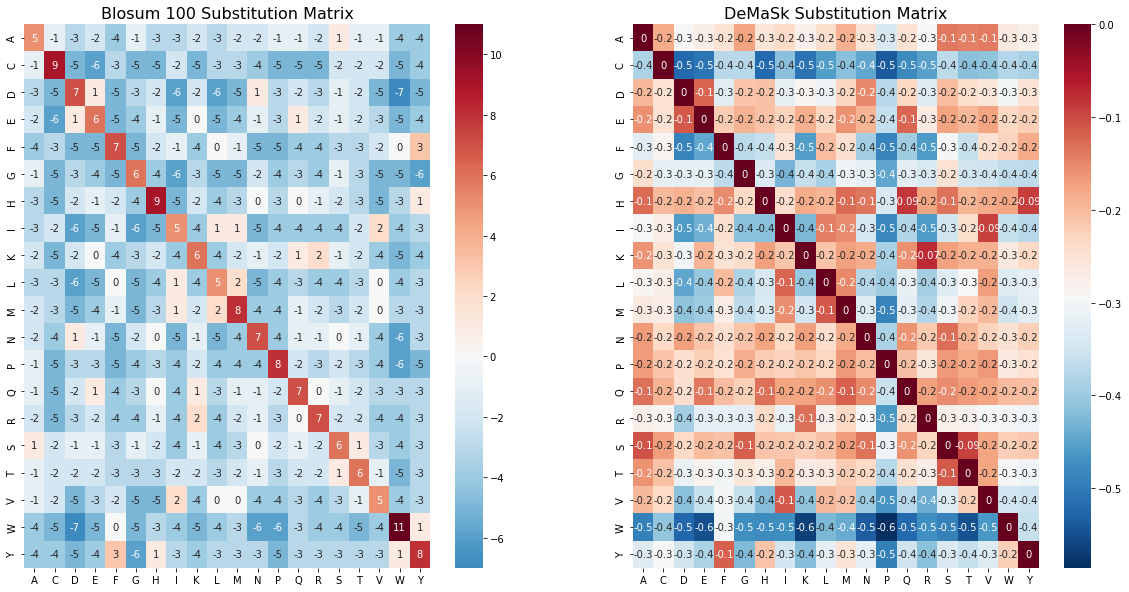

In [14]:
# BLOSUM SUBSTITUTION MATRICES
from Bio.SubsMat import MatrixInfo
def get_sub_matrix(matrix_name="blosum100"):
    sub_matrix = getattr(MatrixInfo, matrix_name)
    sub_matrix.update({(k[1], k[0]):v for k,v in sub_matrix.items() if (k[1], k[0]) not in list(sub_matrix.keys())})
    return sub_matrix
sub_mat_b100 = get_sub_matrix("blosum100")
sub_mat_b80 = get_sub_matrix("blosum80")
sub_mat_b60 = get_sub_matrix("blosum60")
sub_mat_b40 = get_sub_matrix("blosum40")

# DEMASK SUBSTITUTION MATRICES
dff = pd.read_csv('./input/novozymes-xgboost/nesp-test-wildtype-pdb/matrix.txt', sep='\t')
letters = list( dff.columns )
l_dict = {x:y for x,y in zip(letters,range(20))}
sub_mat_demask = {}
for x in letters:
    for y in letters:
        sub_mat_demask[(x,y)] = dff.iloc[l_dict[x],l_dict[y]]

# PLOT MATRICES
AA = np.sort(list(aa_map.values()))
blosum100 = np.zeros((20,20))
demask = np.zeros((20,20))
for (k1,k2),v in sub_mat_b100.items():
    if (k1!='Z')&(k2!='Z')&(k1!='B')&(k2!='B')&(k1!='X')&(k2!='X'):
        blosum100[ aa_map_2[k1], aa_map_2[k2] ] = v
for (k1,k2),v in sub_mat_demask.items():
    if (k1!='Z')&(k2!='Z')&(k1!='B')&(k2!='B')&(k1!='X')&(k2!='X'):
        demask[ aa_map_2[k1], aa_map_2[k2] ] = v
        
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.heatmap(blosum100, cmap='RdBu_r', annot=True, center=0.0)
plt.xticks(np.arange(20)+0.5,AA)
plt.yticks(np.arange(20)+0.5,AA)
plt.title('Blosum 100 Substitution Matrix',size=16)
plt.subplot(1,2,2)
sns.heatmap(demask, cmap='RdBu_r', annot=True, fmt='.1g') #, center=0.0)
plt.xticks(np.arange(20)+0.5,AA)
plt.yticks(np.arange(20)+0.5,AA)
plt.title('DeMaSk Substitution Matrix',size=16)
plt.show()

In [15]:
# https://github.com/facebookresearch/esm
!pip install fair-esm -q

# https://www.kaggle.com/code/kaggleqrdl/esm-quick-start-lb237
import torch, esm
token_map = {'L': 0, 'A': 1, 'G': 2, 'V': 3, 'S': 4, 'E': 5, 'R': 6, 'T': 7, 'I': 8, 'D': 9, 'P': 10, 
         'K': 11, 'Q': 12, 'N': 13, 'F': 14, 'Y': 15, 'M': 16, 'H': 17, 'W': 18, 'C': 19}
t_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
t_model.eval()  # disables dropout for deterministic results
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t_model.to(device)

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

In [16]:
# TRAIN AND TEST WILDTYPES
PCA_CT = 16 # random sample size per protein to fit PCA with
all_pdb = [f for f in df.PDB.unique() if f not in bad]
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
all_pdb_embed_pool = np.zeros((len(all_pdb)+1,1280))
all_pdb_embed_local = []
all_pdb_embed_tmp = []

from scipy.special import softmax 
from scipy.stats import entropy
all_pdb_prob = []

# EXTRACT TRANSFORMER EMBEDDINGS FOR TRAIN AND TEST WILDTYPES
print('Extracting embeddings from proteins...')
for i,p in enumerate(all_pdb+['TEST']):
    
    # WILDTYPE SEQUENCE
    print(p,', ',end='')
    if p=='TEST': seq = base
    else: seq = df.loc[df.PDB==p,'sequence'].iloc[0]
        
    # EXTRACT EMBEDDINGS, MUTATION PROBABILITIES, ENTROPY
    data = [("protein1", seq)]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_tokens = batch_tokens.to(device)
    with torch.no_grad():
        results = t_model(batch_tokens, repr_layers=[33])
    logits = (results['logits'].detach().cpu().numpy()[0,].T)[4:24,1:-1]
    all_pdb_prob.append(softmax(logits,axis=0))
    results = results["representations"][33].detach().cpu().numpy()
    
    # SAVE EMBEDDINGS
    all_pdb_embed_local.append(results)
    all_pdb_embed_pool[i,] = np.mean( results[0,:,:],axis=0 )
    
    # TEMPORARILY SAVE LOCAL MUTATION EMBEDDINGS
    tmp = df.loc[df.PDB==p,'position'].unique()
    if p=='TEST': tmp = np.random.choice(range(20,200),PCA_CT,replace=False)
    if len(tmp)>PCA_CT: tmp = np.random.choice(tmp,PCA_CT,replace=False)
    for j in tmp: all_pdb_embed_tmp.append( results[0,j,:] )
        
    del batch_tokens, results
    gc.collect(); torch.cuda.empty_cache()

all_pdb_embed_tmp = np.stack(all_pdb_embed_tmp)

Extracting embeddings from proteins...
1A43 , 1A5E , 1A7C , 1AAR , 1AG2 , 1AJ3 , 1AKK , 1AM7 , 1ANK , 1APS , 1ARR , 1AXB , 1AYF , 1AYI , 1AZP , 1B0O , 1B10 , 1BFG , 1BFM , 1BNI , 1BP2 , 1BPI , 1BTA , 1BU4 , 1BVC , 1BYW , 1C2R , 1C9O , 1CDC , 1CF3 , 1CHK , 1CQW , 1CSP , 1CYC , 1DIL , 1DIV , 1DKT , 1FKJ , 1FRD , 1FTG , 1FXA , 1G6N , 1G6P , 1H0C , 1H0X , 1H56 , 1H7M , 1HFY , 1HFZ , 1HME , 1HNG , 1HTI , 1HUE , 1IGV , 1IHB , 1IMQ , 1IO2 , 1IOB , 1IRO , 1ITM , 1JY0 , 1K5U , 1K9Q , 1KCQ , 1KFW , 1LS4 , 1LZ1 , 1M21 , 1M7T , 1MBG , 1MGR , 1MJ5 , 1MJC , 1MSI , 1N18 , 1N88 , 1NVO , 1O1U , 1OH0 , 1OIA , 1ONC , 1P2P , 1PDO , 1PFL , 1POH , 1PX0 , 1QGD , 1QLP , 1QM0 , 1QND , 1QQV , 1REI , 1RGG , 1RIL , 1RIS , 1ROP , 1RRO , 1RTB , 1RX4 , 1SHF , 1SHG , 1STN , 1SUP , 1TEN , 1TIT , 1TTG , 1TUP , 1TUX , 1UBQ , 1UWO , 1UZC , 1VII , 1VQB , 1W4E , 1W4H , 1WIT , 1XZO , 1Y4Y , 1Y9X , 1YYJ , 2A01 , 2A36 , 2ABD , 2AFG , 2AKY , 2BJD , 2C9Q , 2DRI , 2DVV , 2GNQ , 2HBB , 2HMB , 2HPR , 2IFB , 2IN9 , 2K3K , 2K7K , 2K

In [17]:
# REDUCE EMBEDDING DIM FROM 1280 TO 32 OR 16 WITH PCA
from sklearn.decomposition import PCA
pca_pool = PCA(n_components=64)
pca_embeds = pca_pool.fit_transform(all_pdb_embed_pool.astype('float32'))
pca_local = PCA(n_components=32)
pca_local.fit(all_pdb_embed_tmp.astype('float32'))
pdb_map = {x:y for x,y in zip(all_pdb,range(len(all_pdb)))}
pdb_map['kaggle'] = len(all_pdb)
del all_pdb_embed_tmp
_ = gc.collect()

In [18]:
print(sum(pca_pool.explained_variance_ratio_))
print(pca_local.explained_variance_ratio_)
print()
print(sum(pca_local.explained_variance_ratio_))
print(pca_local.explained_variance_ratio_)


0.9122491263551638
[0.12693027 0.0629461  0.01883018 0.0152282  0.01289684 0.01229954
 0.01045343 0.00986931 0.00869455 0.00822422 0.00754696 0.00731902
 0.00671235 0.00652478 0.00610151 0.00587118 0.0058218  0.00533338
 0.00516376 0.0049943  0.00494889 0.00486714 0.00457845 0.00452342
 0.00442953 0.00420145 0.00404934 0.00389791 0.00386808 0.00375662
 0.00360095 0.00358891]

0.39807238709181547
[0.12693027 0.0629461  0.01883018 0.0152282  0.01289684 0.01229954
 0.01045343 0.00986931 0.00869455 0.00822422 0.00754696 0.00731902
 0.00671235 0.00652478 0.00610151 0.00587118 0.0058218  0.00533338
 0.00516376 0.0049943  0.00494889 0.00486714 0.00457845 0.00452342
 0.00442953 0.00420145 0.00404934 0.00389791 0.00386808 0.00375662
 0.00360095 0.00358891]


In [19]:
# FEATURE ENGINEER FUNCTION
def get_new_row(atom_df, j, row):
    ##################
    # ATOM_DF - IS PDB FILE'S ATOM_DF
    # J - IS RESIDUE NUMBER WHICH IS TRAIN CSV POSITION PLUS OFFSET
    # ROW - IS ROW FROM DOWNLOADED TRAIN CSV
    ##################
        
    dd = None
    tmp = atom_df.loc[(atom_df.residue_number==j)].reset_index(drop=True)
    prev = atom_df.loc[(atom_df.residue_number==j-1)].reset_index(drop=True)
    post = atom_df.loc[(atom_df.residue_number==j+1)].reset_index(drop=True)
    
    # FEATURE ENGINEER
    if len(tmp)>0:
        
        # GET MUTANT EMBEDDINGS
        data = [("protein1", row.mutant_seq)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        batch_tokens = batch_tokens.to(device)
        with torch.no_grad():
            results = t_model(batch_tokens, repr_layers=[33]) 
        results = results["representations"][33].cpu().numpy()
        mutant_local = pca_local.transform(results[:1,row.position,:])[0,]
        mutant_pool = np.mean( results[:1,:,:],axis=1 )
        mutant_pool = pca_pool.transform(mutant_pool)[0,]
    
        # MUTATION AND POSITION
        dd = {}
        dd['WT'] = row.wildtype
        dd['WT2'] = tmp.residue_name.map(aa_map)[0]
        dd['MUT'] = row.mutation
        dd['position'] = row.position
        dd['relative_position'] = row.position / len(row.sequence)

        # B_FACTOR
        if USE_B_COLUMN: dd['b_factor'] = tmp.b_factor.mean()
        
        # ANIMO ACID PROPERTIES AND DELTAS
        for c in PROPS:
            dd[f'{c}_1'] = aa_props.loc[row.wildtype,c]
            dd[f'{c}_2'] = aa_props.loc[row.mutation,c]
            dd[f'{c}_delta'] = dd[f'{c}_2']-dd[f'{c}_1']
            
        # SUBSTITUTION MATRICES
        dd['blosum100'] = sub_mat_b100[(row.wildtype,row.mutation)]
        dd['blosum80'] = sub_mat_b80[(row.wildtype,row.mutation)]
        dd['blosum60'] = sub_mat_b60[(row.wildtype,row.mutation)]
        dd['blosum40'] = sub_mat_b40[(row.wildtype,row.mutation)]
        dd['demask'] = sub_mat_demask[(row.wildtype,row.mutation)]

        # PREVIOUS AND POST AMINO ACID INFO
        if (len(prev)>0):
            dd['prev'] = prev.residue_name.map(aa_map)[0]
            if USE_B_COLUMN: dd['b_factor_prev'] = prev.b_factor.mean()
        else:
            dd['prev'] = 'X'
            if USE_B_COLUMN: dd['b_factor_prev'] = -999            
            
        if (len(post)>0):
            dd['post'] = post.residue_name.map(aa_map)[0]
            if USE_B_COLUMN: dd['b_factor_post'] = post.b_factor.mean() 
        else:
            dd['post'] = 'X'
            if USE_B_COLUMN: dd['b_factor_post'] = -999 
            
        # ANGLE BETWEEN MUTATION AND NEIGHBORS
        if (len(prev)>0)&(len(post)>0):
            # BACKBONE ATOMS
            atm = ['N','H','CA','O']
            prev = prev.loc[prev.atom_name.isin(atm)]
            tmp = tmp.loc[tmp.atom_name.isin(atm)]
            post = post.loc[post.atom_name.isin(atm)]
            # VECTORS
            c_prev = np.array( [prev.x_coord.mean(),prev.y_coord.mean(),prev.z_coord.mean()] )
            c_tmp = np.array( [tmp.x_coord.mean(),tmp.y_coord.mean(),tmp.z_coord.mean()] )
            c_post = np.array( [post.x_coord.mean(),post.y_coord.mean(),post.z_coord.mean()] )
            vec_a = c_prev - c_tmp
            vec_b = c_post - c_tmp
            # COMPUTE ANGLE
            norm_a = np.sqrt(vec_a.dot(vec_a))
            norm_b = np.sqrt(vec_b.dot(vec_b))
            dd['cos_angle'] = vec_a.dot(vec_b)/norm_a/norm_b
        else:
            dd['cos_angle'] = -2
            
        # 3D LOCATION OF MUTATION
        atm = ['N','H','CA','O']
        atoms = atom_df.loc[atom_df.atom_name.isin(atm)]
        centroid1 = np.array( [atoms.x_coord.mean(),atoms.y_coord.mean(),atoms.z_coord.mean()] )
        tmp = tmp.loc[tmp.atom_name.isin(atm)]
        centroid2 = np.array( [tmp.x_coord.mean(),tmp.y_coord.mean(),tmp.z_coord.mean()] )
        dist = centroid2 - centroid1
        dd['location3d'] = dist.dot(dist)
        
        # TRANSFORMER ESM EMBEDDINGS
        wt_local = pca_local.transform(all_pdb_embed_local[pdb_map[row.PDB]][:1,row.position,:])[0,]
        wt_pool = pca_embeds[pdb_map[row.PDB],]
        for kk in range(32):
            dd[f'pca_pool_{kk}'] = mutant_pool[kk] - wt_pool[kk]
            if kk>=16: continue
            dd[f'pca_wt_{kk}'] = wt_local[kk]
            dd[f'pca_mutant_{kk}'] = mutant_local[kk]
            dd[f'pca_local_{kk}'] = mutant_local[kk] - wt_local[kk]
            
        # TRANSFORMER MUTATION PROBS AND ENTROPY
        dd['mut_prob'] = all_pdb_prob[pdb_map[row.PDB]][token_map[dd['MUT']],dd['position']-1]
        dd['mut_entropy'] = entropy( all_pdb_prob[pdb_map[row.PDB]][:,dd['position']-1] )
        
        # SURFACE AREA FEATURES
        PATH = './input/novozymes-xgboost/nesp-kaggle-train-surface-area/'
        if row.CIF: 
            nm = f'{row.CIF}-model_v3.csv'
        elif row.PDB!='kaggle': 
            PATH = './input/novozymes-xgboost/nesp-jin-external-surface-area/'
            nm = f'{row.PDB}.csv'
        else: 
            nm = 'wildtype_structure_prediction_af2_SASA.csv'
        try:    
            area = pd.read_csv(f'{PATH}{nm}')
            rw = area.loc[area.Residue_number==j].iloc[0]
            dd['sa_total'] = rw.Total
            dd['sa_apolar'] = rw.Apolar
            dd['sa_backbone'] = rw.Backbone
            dd['sa_sidechain'] = rw.Sidechain
            dd['sa_ratio'] = rw.Ratio
            dd['sa_in/out'] = -1
            if rw['In/Out']=='i': dd['sa_in/out'] = 1
            elif rw['In/Out']=='o': dd['sa_in/out'] = 0
        except:
            print('### NEED SURFACE AREA for PDB:',row.PDB,'residue_number:',j)
            return None
        
        # LABEL ENCODE AMINO ACIDS
        dd['AA1'] = aa_map_2[dd['WT']]
        dd['AA2'] = aa_map_2[dd['MUT']]
        dd['AA3'] = aa_map_2[dd['prev']]
        dd['AA4'] = aa_map_2[dd['post']]
        
        # TARGETS AND SOURCES
        dd['ddG'] = row.ddG
        dd['dTm'] = row.dTm
        dd['pdb'] = row.PDB
        dd['source'] = row.source
        
        del batch_tokens, results, mutant_local, mutant_pool, wt_local, wt_pool
        gc.collect(); torch.cuda.empty_cache()

    return dd

In [20]:
pdb = None
rows = []
offsets = []

for index,row in df.iterrows():
    if row.PDB in bad: continue
        
    # READ PDB FILE WHICH CONTAINS MORE INFO ABOUT PROTEIN
    first = False
    if row.PDB != pdb:
        pdb = row.PDB
        if row.CIF:
            atom_df = PandasMmcif().read_mmcif(f'./input/novozymes-xgboost/train-wildtypes-af/cif/{row.CIF}-model_v3.cif')
            atom_df = atom_df.df['ATOM']
            atom_df = atom_df.rename({'label_seq_id':'residue_number','label_comp_id':'residue_name'},axis=1)
            atom_df = atom_df.rename({'Cartn_x':'x_coord','Cartn_y':'y_coord','Cartn_z':'z_coord'},axis=1)
            atom_df = atom_df.rename({'B_iso_or_equiv':'b_factor','label_atom_id':'atom_name'},axis=1)
        else:
            atom_df = PandasPdb().read_pdb(f'./input/novozymes-xgboost/downloaded_pdb/{row.PDB}.pdb')
            atom_df = atom_df.df['ATOM']
        first = True

    # VERY IMPORTANT - ALIGN SEQUENCES
    # THE RESIDUE NUMBERS IN PDB FILES DONT MATCH THE POSTION NUMBERS IN CSV FILE!
    tmp = atom_df.drop_duplicates(['residue_name','residue_number']).sort_values('residue_number')
    tmp = tmp.iloc[20:36].reset_index(drop=True)
    d = (tmp.residue_number.diff()!=1.0).sum()
    if d>1: print(f'=> ERROR missing consecutive amino acids in PDB file {row.PDB}')
    tmp['letter'] = tmp.residue_name.map(aa_map)  
    pdb_seq = (''.join( tmp.letter.values ))
    csv_seq = df.loc[df.PDB==row.PDB,'sequence'].values[0]
    i = csv_seq.find(pdb_seq)
    if i==-1: print('=> ERROR cannot find PDB sequence in CSV sequence for {row.PDB}')
    x = tmp.loc[0,'residue_number']
    offset = (x-i)-1
    if first: 
        print(f'{row.PDB} PDB residue_number equals {offset} added to position in CSV')
        dd = {}
        dd['pdb'] = row.PDB
        dd['offset'] = offset
        offsets.append(dd)
    
    # FEATURE ENGINEER
    j = row.position + offset
    dd = get_new_row(atom_df, j, row)
    if dd is not None:
        rows.append(dd)

1A43 PDB residue_number equals 147 added to position in CSV
1A5E PDB residue_number equals 0 added to position in CSV
1A7C PDB residue_number equals 1 added to position in CSV
1AAR PDB residue_number equals 0 added to position in CSV
1AG2 PDB residue_number equals 123 added to position in CSV
1AJ3 PDB residue_number equals 9 added to position in CSV
1AKK PDB residue_number equals 0 added to position in CSV
1AM7 PDB residue_number equals 1 added to position in CSV
1ANK PDB residue_number equals 0 added to position in CSV
1APS PDB residue_number equals 0 added to position in CSV
1ARR PDB residue_number equals 0 added to position in CSV
1AXB PDB residue_number equals 2 added to position in CSV
1AYF PDB residue_number equals 5 added to position in CSV
1AYI PDB residue_number equals 0 added to position in CSV
1AZP PDB residue_number equals 0 added to position in CSV
1B0O PDB residue_number equals 1 added to position in CSV
1B10 PDB residue_number equals 124 added to position in CSV
1BFG PDB

In [21]:
atom_df.head()

group_PDB  id type_symbol atom_name label_alt_id residue_name label_asym_id  \
0      ATOM   1           N         N         None          MET             A   
1      ATOM   2           C        CA         None          MET             A   
2      ATOM   3           C         C         None          MET             A   
3      ATOM   4           C        CB         None          MET             A   
4      ATOM   5           O         O         None          MET             A   

   label_entity_id  residue_number pdbx_PDB_ins_code  x_coord  y_coord  \
0                1               1              None  -42.637   42.820   
1                1               1              None  -41.326   42.215   
2                1               1              None  -41.235   40.705   
3                1               1              None  -40.894   42.545   
4                1               1              None  -40.193   40.264   

   z_coord  occupancy  b_factor pdbx_formal_charge  auth_seq_id auth_comp_id  \
0   33.757        1.0     62.46               None            1          MET   
1   34.112        1.0     62.46               None            1          MET   
2   33.860        1.0     62.46               None            1          MET   
3   35.547        1.0     62.46               None            1          MET   
4   33.396        1.0     62.46               None            1          MET   

  auth_asym_id auth_atom_id  pdbx_PDB_model_num pdbx_sifts_xref_db_acc  \
0            A            N                   1                 P07998   
1            A           CA                   1                 P07998   
2            A            C                   1                 P07998   
3            A           CB                   1                 P07998   
4            A            O                   1                 P07998   

  pdbx_sifts_xref_db_name pdbx_sifts_xref_db_num pdbx_sifts_xref_db_res  
0                     UNP                      1                      M  
1                     UNP                      1                      M  
2                     UNP                      1                      M  
3                     UNP                      1                      M  
4                     UNP                      1                      M

In [22]:
import os
os.environ['KAGGLE_USERNAME'] = 'sangminnnn'
os.environ['KAGGLE_KEY'] = '520c3f2aae04edf0a6ce397c15d74fd3'

In [23]:
# ADD THESE OFFSETS TO CSV'S POSITION TO GET PDB'S RESIDUE NUMBER
offsets = pd.DataFrame(offsets)
offsets = offsets.loc[offsets.pdb.str[:2]!='GP'] # drop kaggle CIF
if len(offsets)>0:
    offsets.to_csv('./input/novozymes-xgboost/downloaded_csv/PDB_offset_from_CSV.csv',index=False)
    print('Add these offsets to CSV position to get PDB residue number')
    display( offsets.head() )

Add these offsets to CSV position to get PDB residue number


pdb  offset
0  1A43     147
1  1A5E       0
2  1A7C       1
3  1AAR       0
4  1AG2     123

In [24]:
print(dd)
rows
# train = pd.DataFrame(rows)
# print(train)

{'WT': 'S', 'WT2': 'S', 'MUT': 'N', 'position': 45, 'relative_position': 0.28846153846153844, 'Molecular Weight_1': 105.09, 'Molecular Weight_2': 132.12, 'Molecular Weight_delta': 27.03, 'Residue Weight_1': 87.08, 'Residue Weight_2': 114.11, 'Residue Weight_delta': 27.03, 'pKa1_1': 2.21, 'pKa1_2': 2.02, 'pKa1_delta': -0.18999999999999995, 'pKb2_1': 9.15, 'pKb2_2': 8.8, 'pKb2_delta': -0.34999999999999964, 'pKx3_1': nan, 'pKx3_2': nan, 'pKx3_delta': nan, 'pl4_1': 5.68, 'pl4_2': 5.41, 'pl4_delta': -0.2699999999999996, 'H_1': -0.18, 'H_2': -0.78, 'H_delta': -0.6000000000000001, 'VSC_1': 29.3, 'VSC_2': 58.7, 'VSC_delta': 29.400000000000002, 'P1_1': 9.2, 'P1_2': 11.6, 'P1_delta': 2.4000000000000004, 'P2_1': 0.062, 'P2_2': 0.134, 'P2_delta': 0.07200000000000001, 'SASA_1': 1.298, 'SASA_2': 1.655, 'SASA_delta': 0.357, 'NCISC_1': 0.004627, 'NCISC_2': 0.005392, 'NCISC_delta': 0.0007650000000000001, 'blosum100': 0, 'blosum80': 0, 'blosum60': 1, 'blosum40': 1, 'demask': -0.1346, 'prev': 'D', 'post'

[{'WT': 'G',
  'WT2': 'G',
  'MUT': 'A',
  'position': 9,
  'relative_position': 0.125,
  'Molecular Weight_1': 75.07,
  'Molecular Weight_2': 89.1,
  'Molecular Weight_delta': 14.030000000000001,
  'Residue Weight_1': 57.05,
  'Residue Weight_2': 71.08,
  'Residue Weight_delta': 14.030000000000001,
  'pKa1_1': 2.34,
  'pKa1_2': 2.34,
  'pKa1_delta': 0.0,
  'pKb2_1': 9.6,
  'pKb2_2': 9.69,
  'pKb2_delta': 0.08999999999999986,
  'pKx3_1': nan,
  'pKx3_2': nan,
  'pKx3_delta': nan,
  'pl4_1': 5.97,
  'pl4_2': 6.0,
  'pl4_delta': 0.03000000000000025,
  'H_1': 0.48,
  'H_2': 0.62,
  'H_delta': 0.14,
  'VSC_1': 0.0,
  'VSC_2': 27.5,
  'VSC_delta': 27.5,
  'P1_1': 9.0,
  'P1_2': 8.1,
  'P1_delta': -0.9000000000000004,
  'P2_1': 0.0,
  'P2_2': 0.046,
  'P2_delta': 0.046,
  'SASA_1': 0.881,
  'SASA_2': 1.181,
  'SASA_delta': 0.30000000000000004,
  'NCISC_1': 0.179052,
  'NCISC_2': 0.007187,
  'NCISC_delta': -0.171865,
  'blosum100': -1,
  'blosum80': 0,
  'blosum60': 0,
  'blosum40': 1,
  'dem

In [25]:
# CREATE EXTERNAL TRAIN DATAFRAME
train = pd.DataFrame(rows)
train = train.loc[train.WT == train.WT2].reset_index(drop=True)
print('Train plus Holdout data shape', train.shape )
train['ct'] = train.groupby('pdb').WT.transform('count')
train = train.loc[train.ct>EXCLUDE_CT_UNDER].reset_index(drop=True)
train = train.drop(['WT2','ct'],axis=1)
print('Data shape after removing small mutation groups', train.shape )

Train plus Holdout data shape (6463, 146)
Data shape after removing small mutation groups (4944, 145)


In [26]:
# RANK NORMALIZE ddG AND dTm TARGETS SO ALL CAN BE MIXED TOGETHER
train['target'] = 0.5
for g in train.pdb.unique():
    target = 'dTm'
    tmp = train.loc[train.pdb==g,'dTm']
    if tmp.isna().sum()>len(tmp)/2: target = 'ddG'
    train.loc[train.pdb==g,'target'] =\
        rankdata(train.loc[train.pdb==g,target])/len(train.loc[train.pdb==g,target])
train.head()

WT MUT  position  relative_position  Molecular Weight_1  Molecular Weight_2  \
0  H   A         1           0.010204              155.16               89.10   
1  H   G         1           0.010204              155.16               75.07   
2  F   A         3           0.030612              165.19               89.10   
3  F   L         3           0.030612              165.19              131.18   
4  R   A         5           0.051020              174.20               89.10   

   Molecular Weight_delta  Residue Weight_1  Residue Weight_2  \
0                  -66.06            137.14             71.08   
1                  -80.09            137.14             57.05   
2                  -76.09            147.18             71.08   
3                  -34.01            147.18            113.16   
4                  -85.10            156.19             71.08   

   Residue Weight_delta  pKa1_1  pKa1_2  pKa1_delta  pKb2_1  pKb2_2  \
0                -66.06    1.82    2.34        0.52    9.17    9.69   
1                -80.09    1.82    2.34        0.52    9.17    9.60   
2                -76.10    1.83    2.34        0.51    9.13    9.69   
3                -34.02    1.83    2.36        0.53    9.13    9.60   
4                -85.11    2.17    2.34        0.17    9.04    9.69   

   pKb2_delta  pKx3_1  pKx3_2  pKx3_delta  pl4_1  pl4_2  pl4_delta   H_1  \
0        0.52    6.00     NaN         NaN   7.59   6.00      -1.59 -0.40   
1        0.43    6.00     NaN         NaN   7.59   5.97      -1.62 -0.40   
2        0.56     NaN     NaN         NaN   5.48   6.00       0.52  1.19   
3        0.47     NaN     NaN         NaN   5.48   5.98       0.50  1.19   
4        0.65   12.48     NaN         NaN  10.76   6.00      -4.76 -2.53   

    H_2  H_delta  VSC_1  VSC_2  VSC_delta  P1_1  P1_2  P1_delta   P2_1   P2_2  \
0  0.62     1.02   79.0   27.5      -51.5  10.4   8.1      -2.3  0.230  0.046   
1  0.48     0.88   79.0    0.0      -79.0  10.4   9.0      -1.4  0.230  0.000   
2  0.62    -0.57  115.5   27.5      -88.0   5.2   8.1       2.9  0.290  0.046   
3  1.06    -0.13  115.5   93.5      -22.0   5.2   4.9      -0.3  0.290  0.186   
4  0.62     3.15  105.0   27.5      -77.5  10.5   8.1      -2.4  0.291  0.046   

   P2_delta  SASA_1  SASA_2  SASA_delta   NCISC_1   NCISC_2  NCISC_delta  \
0    -0.184   2.025   1.181      -0.844 -0.010690  0.007187     0.017877   
1    -0.230   2.025   0.881      -1.144 -0.010690  0.179052     0.189742   
2    -0.244   2.228   1.181      -1.047  0.037552  0.007187    -0.030365   
3    -0.104   2.228   1.931      -0.297  0.037552  0.051672     0.014120   
4    -0.245   2.560   1.181      -1.379  0.043587  0.007187    -0.036400   

   blosum100  blosum80  blosum60  blosum40  demask prev post  cos_angle  \
0         -3        -2        -2        -2 -0.1271    X    Q  -2.000000   
1         -4        -3        -2        -2 -0.2352    X    Q  -2.000000   
2         -4        -3        -2        -3 -0.3264    Q    F  -0.133476   
3          0         0         0         2 -0.2034    Q    F  -0.133476   
4         -2        -2        -1        -2 -0.2748    F    D  -0.142559   

   location3d  pca_pool_0  pca_wt_0  pca_mutant_0  pca_local_0  pca_pool_1  \
0  428.159734   -0.059646 -1.769657     -1.853487    -0.083830   -0.031325   
1  428.159734   -0.070258 -1.769657     -2.078108    -0.308451   -0.006981   
2  272.373475   -0.068368  1.451343      0.408609    -1.042734    0.011674   
3  272.373475   -0.016893  1.451343      1.144591    -0.306751    0.032206   
4  228.340857   -0.041020 -2.158355     -2.190099    -0.031744   -0.029550   

   pca_wt_1  pca_mutant_1  pca_local_1  pca_pool_2  pca_wt_2  pca_mutant_2  \
0 -0.187350     -0.211051    -0.023701    0.014654  0.529299      0.080068   
1 -0.187350      0.120392     0.307743    0.010339  0.529299      0.461679   
2 -3.370655     -3.025860     0.344795    0.012406  2.019169      1.431592   
3 -3.370655     -3.792612    -0.421957    0.013345  2.019169    

In [27]:
# USE some sources TO TRAIN/VALIDATE AND other sources TO HOLDOUT VALIDATE
holdout = train.loc[train.source.isin(HOLDOUT_SOURCES)].reset_index(drop=True)
train = train.loc[train.source.isin(KFOLD_SOURCES)].reset_index(drop=True)

# LABEL ENCODE GROUPS FOR GROUP K FOLD
train['group'],_ = train.pdb.factorize()
holdout['group'],_ = holdout.pdb.factorize()

In [28]:
EXCLUDE = ['WT','MUT','prev','post','ddG','dTm','pdb','source','target','group','oof']
FEATURES = [c for c in train.columns if c not in EXCLUDE]
print(f'We have {len(FEATURES)} features for our model:')
print( FEATURES )

We have 137 features for our model:
['position', 'relative_position', 'Molecular Weight_1', 'Molecular Weight_2', 'Molecular Weight_delta', 'Residue Weight_1', 'Residue Weight_2', 'Residue Weight_delta', 'pKa1_1', 'pKa1_2', 'pKa1_delta', 'pKb2_1', 'pKb2_2', 'pKb2_delta', 'pKx3_1', 'pKx3_2', 'pKx3_delta', 'pl4_1', 'pl4_2', 'pl4_delta', 'H_1', 'H_2', 'H_delta', 'VSC_1', 'VSC_2', 'VSC_delta', 'P1_1', 'P1_2', 'P1_delta', 'P2_1', 'P2_2', 'P2_delta', 'SASA_1', 'SASA_2', 'SASA_delta', 'NCISC_1', 'NCISC_2', 'NCISC_delta', 'blosum100', 'blosum80', 'blosum60', 'blosum40', 'demask', 'cos_angle', 'location3d', 'pca_pool_0', 'pca_wt_0', 'pca_mutant_0', 'pca_local_0', 'pca_pool_1', 'pca_wt_1', 'pca_mutant_1', 'pca_local_1', 'pca_pool_2', 'pca_wt_2', 'pca_mutant_2', 'pca_local_2', 'pca_pool_3', 'pca_wt_3', 'pca_mutant_3', 'pca_local_3', 'pca_pool_4', 'pca_wt_4', 'pca_mutant_4', 'pca_local_4', 'pca_pool_5', 'pca_wt_5', 'pca_mutant_5', 'pca_local_5', 'pca_pool_6', 'pca_wt_6', 'pca_mutant_6', 'pca_local

In [29]:
# LOAD XGB LIBRARY
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
print('XGB Version',xgb.__version__)

FOLDS = 11
SEED = 123

# XGB MODEL PARAMETERS
xgb_parms = { 
    'max_depth':4, 
    'learning_rate':0.001, 
    'subsample':0.6,
    'colsample_bytree':0.2, 
    'eval_metric':'rmse',
    'objective':'reg:squarederror',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

XGB Version 1.5.0


In [30]:
%%time
importances = []
importances2 = []
oof = np.zeros(len(train))
preds = np.zeros(len(holdout))
os.system('mkdir ./input/novozymes-xgboost/xgb_models')

skf = GroupKFold(n_splits=FOLDS)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target, train.group )):
        
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print('#'*25)
    
    # TRAIN, VALID, HOLDOUT FOR FOLD K
    X_train = train.loc[train_idx, FEATURES]
    y_train = train.loc[train_idx,'target']
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']
    X_holdout = holdout[FEATURES]
    
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    dholdout = xgb.DMatrix(data=X_holdout)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    model.save_model(f'./input/novozymes-xgboost/xgb_models/XGB_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
    dd = model.get_score(importance_type='gain')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances2.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    rsme = mean_squared_error(y_valid.values, oof_preds, squared=False)
    print('RSME =',rsme,'\n')
    oof[valid_idx] = oof_preds
    
    # HOLDOUT PREDS
    if len(holdout)>0:
        p = model.predict(dholdout)
        preds += p/FOLDS
    
    del dtrain, X_train, y_train, dd, df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    
print('#'*25)
rsme = mean_squared_error(train.target.values, oof, squared=False)
print('OVERALL RSME =',rsme,'\n')

train['oof'] = oof
if len(holdout)>0: holdout['preds'] = preds

#########################
### Fold 1
### Train size 3241 Valid size 526
#########################
[0]	train-rmse:0.28832	valid-rmse:0.28852
[100]	train-rmse:0.28264	valid-rmse:0.28226
[200]	train-rmse:0.27746	valid-rmse:0.27654
[300]	train-rmse:0.27277	valid-rmse:0.27145
[400]	train-rmse:0.26843	valid-rmse:0.26668
[500]	train-rmse:0.26442	valid-rmse:0.26230
[600]	train-rmse:0.26077	valid-rmse:0.25835
[700]	train-rmse:0.25738	valid-rmse:0.25489
[800]	train-rmse:0.25426	valid-rmse:0.25169
[900]	train-rmse:0.25133	valid-rmse:0.24870
[1000]	train-rmse:0.24858	valid-rmse:0.24588
[1100]	train-rmse:0.24607	valid-rmse:0.24333
[1200]	train-rmse:0.24370	valid-rmse:0.24110
[1300]	train-rmse:0.24144	valid-rmse:0.23894
[1400]	train-rmse:0.23933	valid-rmse:0.23707
[1500]	train-rmse:0.23739	valid-rmse:0.23543
[1600]	train-rmse:0.23547	valid-rmse:0.23378
[1700]	train-rmse:0.23364	valid-rmse:0.23217
[1800]	train-rmse:0.23191	valid-rmse:0.23081
[1900]	train-rmse:0.23026	valid-rmse:0.22944
[2000]	train-r

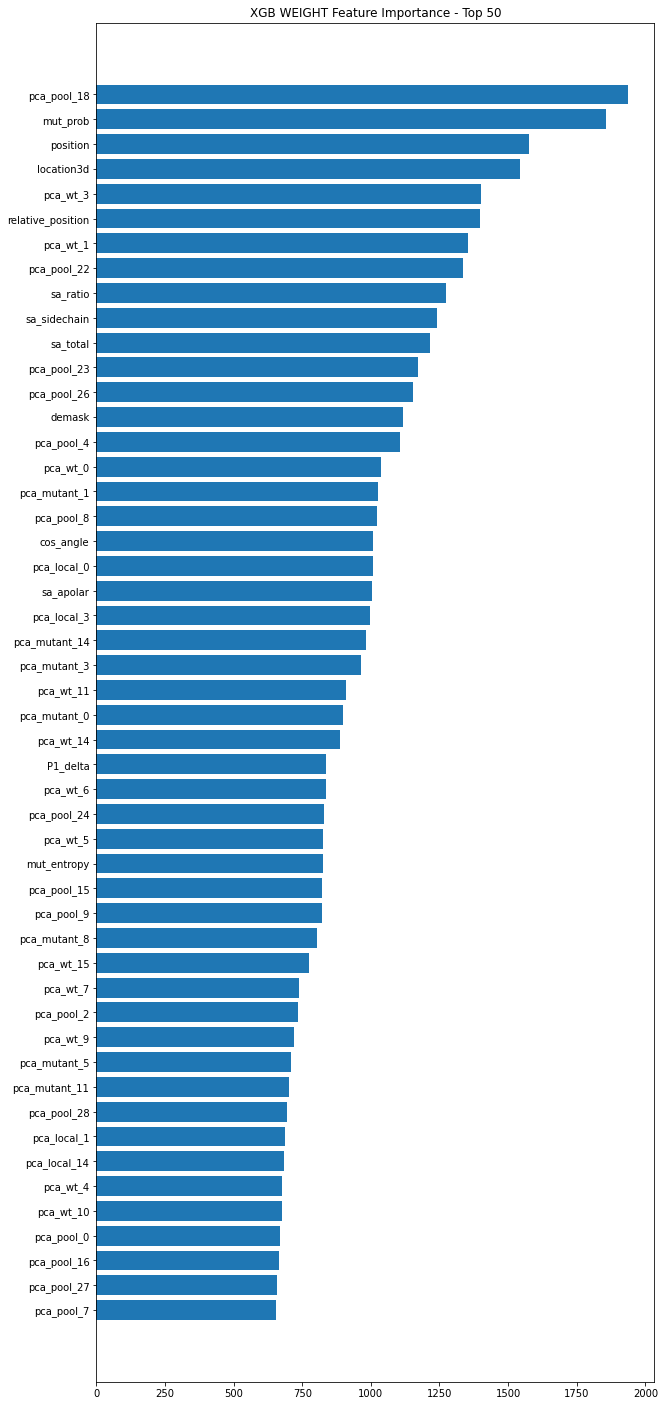

In [31]:
df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
NUM_FEATURES = 50 #len(df)
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB WEIGHT Feature Importance - Top {NUM_FEATURES}')
plt.show()

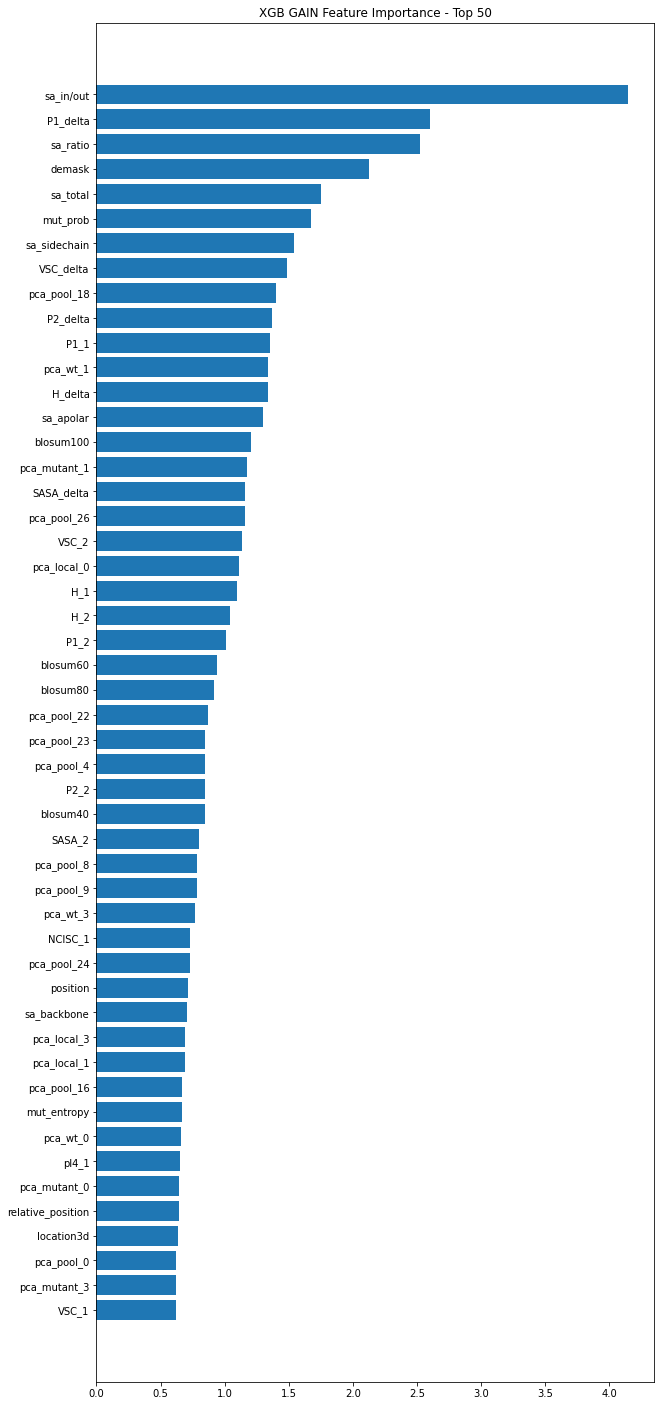

In [32]:
df = importances2[0].copy()
for k in range(1,FOLDS): df = df.merge(importances2[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
NUM_FEATURES = 50 #len(df)
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB GAIN Feature Importance - Top {NUM_FEATURES}')
plt.show()

In [33]:
sp = []; sp_dtm = []; sp_ddg = []
for p in train.pdb.unique():

    tmp = train.loc[train.pdb==p].reset_index(drop=True)
    ttarget = 'dTm'
    if tmp['dTm'].isna().sum()>len(tmp)/2: ttarget = 'ddG'
    print('Protein',p,'has mutation count =',len(tmp),'and target =',ttarget)
    r = np.abs( spearmanr(tmp.oof.values, tmp[ttarget].values).correlation )
    print('Spearman Metric =',r)
    sp.append(r)
    if ttarget=='dTm': sp_dtm.append(r)
    else: sp_ddg.append(r)
    print()

print('#'*25)
if len(sp_dtm)>0:
    print(f'Overall Spearman Metric (predicting dTm) =',np.nanmean(sp_dtm))
if len(sp_ddg)>0:
    print(f'Overall Spearman Metric (predicting ddG) =',np.nanmean(sp_ddg))

Protein 1AJ3 has mutation count = 66 and target = ddG
Spearman Metric = 0.7221522826097067

Protein 1APS has mutation count = 27 and target = ddG
Spearman Metric = 0.46297149459774073

Protein 1ARR has mutation count = 59 and target = ddG
Spearman Metric = 0.7425849095964178

Protein 1BNI has mutation count = 171 and target = ddG
Spearman Metric = 0.6993018993302211

Protein 1BPI has mutation count = 66 and target = ddG
Spearman Metric = 0.8125509740787322

Protein 1BU4 has mutation count = 71 and target = ddG
Spearman Metric = 0.7443510080371013

Protein 1BVC has mutation count = 73 and target = ddG
Spearman Metric = 0.7369476728560069

Protein 1CSP has mutation count = 50 and target = ddG
Spearman Metric = 0.6190784894579003

Protein 1FKJ has mutation count = 53 and target = ddG
Spearman Metric = 0.7751144123405747

Protein 1FTG has mutation count = 45 and target = ddG
Spearman Metric = 0.5499522385143608

Protein 1H7M has mutation count = 28 and target = ddG
Spearman Metric = 0.3990

In [34]:
sp = []; sp_dtm = []; sp_ddg = []
for p in holdout.pdb.unique():

    tmp = holdout.loc[holdout.pdb==p].reset_index(drop=True)
    ttarget = 'dTm'
    if tmp['dTm'].isna().sum()>len(tmp)/2: ttarget = 'ddG'
    print('Protein',p,'has mutation count =',len(tmp),'and target =',ttarget)
    r = np.abs( spearmanr(tmp.preds.values, tmp[ttarget].values).correlation )
    print('Spearman Metric =',r)
    sp.append(r)
    if ttarget=='dTm': sp_dtm.append(r)
    else: sp_ddg.append(r)
    print()

print('#'*25)
if len(sp_dtm)>0:
    print(f'Overall Spearman Metric (predicting dTm) =',np.nanmean(sp_dtm))
if len(sp_ddg)>0:
    print(f'Overall Spearman Metric (predicting ddG) =',np.nanmean(sp_ddg))

Protein GP01 has mutation count = 185 and target = dTm
Spearman Metric = 0.6696908990910815

Protein GP02 has mutation count = 211 and target = dTm
Spearman Metric = 0.693039411785519

Protein GP06 has mutation count = 56 and target = dTm
Spearman Metric = 0.16061458631452835

Protein GP07 has mutation count = 77 and target = dTm
Spearman Metric = 0.6028450562953093

Protein GP08 has mutation count = 55 and target = dTm
Spearman Metric = 0.28685711173004436

Protein GP09 has mutation count = 30 and target = dTm
Spearman Metric = 0.8714810767075626

Protein GP10 has mutation count = 84 and target = dTm
Spearman Metric = 0.5592233987284189

Protein GP11 has mutation count = 46 and target = dTm
Spearman Metric = 0.21339050830424558

Protein GP12 has mutation count = 78 and target = dTm
Spearman Metric = 0.6421227080910613

Protein GP14 has mutation count = 45 and target = dTm
Spearman Metric = 0.5342907976546327

Protein GP16 has mutation count = 33 and target = dTm
Spearman Metric = 0.74

In [35]:
# LOAD TEST WILDTYPE
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
len(base)

221

In [36]:
# LOAD TEST DATA
test = pd.read_csv('./input/novozymes-xgboost/novozymes-enzyme-stability-prediction/test.csv')
deletions = test.loc[test.protein_sequence.str.len()==220,'seq_id'].values
print('Test shape', test.shape )
test.head()

Test shape (2413, 4)


seq_id                                   protein_sequence  pH data_source
0   31390  VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   Novozymes
1   31391  VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   Novozymes
2   31392  VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...   8   Novozymes
3   31393  VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   Novozymes
4   31394  VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   Novozymes

In [37]:
# LOAD TEST DATA PDB FILE 
# NOTE KAGGLE'S PDB IS GENERATED BY ALPHA FOLD AND CONTAINS PLDDT IN B_FACTOR COLUMN
# WHEN TRAINING WITH KAGGLE.CSV WE NEED ALPHA FOLD PDB
# WHEN TRAINING WITH JIN DATA WE NEED PROTEIN DATA BANK PDB (with real b_factor)
if USE_PLDDT_INFER:
    atom_df = PandasPdb().read_pdb('./input/novozymes-xgboost/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb')
else:
    atom_df = PandasPdb().read_pdb('./input/novozymes-xgboost/nesp-test-wildtype-pdb/model.pdb')
atom_df = atom_df.df['ATOM']
atom_df.head()

record_name  atom_number blank_1 atom_name alt_loc residue_name blank_2  \
0        ATOM            1                 N                  VAL           
1        ATOM            2                 H                  VAL           
2        ATOM            3                H2                  VAL           
3        ATOM            4                H3                  VAL           
4        ATOM            5                CA                  VAL           

  chain_id  residue_number insertion blank_3  x_coord  y_coord  z_coord  \
0        A               1                     34.064   -6.456   50.464   
1        A               1                     33.576   -6.009   51.228   
2        A               1                     33.882   -7.449   50.477   
3        A               1                     35.060   -6.323   50.566   
4        A               1                     33.643   -5.877   49.162   

   occupancy  b_factor blank_4 segment_id element_symbol  charge  line_idx  
0        1.0     42.82   10.46                               NaN         2  
1        1.0     42.82   10.46                               NaN         3  
2        1.0     42.82   10.46                               NaN         4  
3        1.0     42.82   10.46                               NaN         5  
4        1.0     42.82   10.46                               NaN         6

In [38]:
def get_test_mutation(row):
    for i,(a,b) in enumerate(zip(row.protein_sequence,base)):
        if a!=b: break
    row['wildtype'] = base[i]
    row['mutation'] = row.protein_sequence[i]
    row['position'] = i+1
    return row

# TRANSFORM TEST DATAFRAME TO MATCH TRAIN DATAFRAME
test = test.apply(get_test_mutation,axis=1)
test['ddG'] = np.nan
test['dTm'] = np.nan
test['CIF'] = None
test['sequence'] = base
test = test.rename({'protein_sequence':'mutant_seq'},axis=1)
test['source'] = 'kaggle'
test['PDB'] = 'kaggle'

# FEATURE ENGINEER TEST DATA
rows = []
print(f'Extracting embeddings and feature engineering {len(test)} test rows...')
for index,row in test.iterrows():
    if index%10==0: print(index,', ',end='')
    j = row.position
    dd = get_new_row(atom_df, j, row)
    rows.append(dd)
test = pd.DataFrame(rows)
test.head()

Extracting embeddings and feature engineering 2413 test rows...
0 , 10 , 20 , 30 , 40 , 50 , 60 , 70 , 80 , 90 , 100 , 110 , 120 , 130 , 140 , 150 , 160 , 170 , 180 , 190 , 200 , 210 , 220 , 230 , 240 , 250 , 260 , 270 , 280 , 290 , 300 , 310 , 320 , 330 , 340 , 350 , 360 , 370 , 380 , 390 , 400 , 410 , 420 , 430 , 440 , 450 , 460 , 470 , 480 , 490 , 500 , 510 , 520 , 530 , 540 , 550 , 560 , 570 , 580 , 590 , 600 , 610 , 620 , 630 , 640 , 650 , 660 , 670 , 680 , 690 , 700 , 710 , 720 , 730 , 740 , 750 , 760 , 770 , 780 , 790 , 800 , 810 , 820 , 830 , 840 , 850 , 860 , 870 , 880 , 890 , 900 , 910 , 920 , 930 , 940 , 950 , 960 , 970 , 980 , 990 , 1000 , 1010 , 1020 , 1030 , 1040 , 1050 , 1060 , 1070 , 1080 , 1090 , 1100 , 1110 , 1120 , 1130 , 1140 , 1150 , 1160 , 1170 , 1180 , 1190 , 1200 , 1210 , 1220 , 1230 , 1240 , 1250 , 1260 , 1270 , 1280 , 1290 , 1300 , 1310 , 1320 , 1330 , 1340 , 1350 , 1360 , 1370 , 1380 , 1390 , 1400 , 1410 , 1420 , 1430 , 1440 , 1450 , 1460 , 1470 , 1480 , 1490

WT WT2 MUT  position  relative_position  Molecular Weight_1  \
0  L   L   E        17           0.076923              131.18   
1  L   L   K        17           0.076923              131.18   
2  L   L   K        17           0.076923              131.18   
3  K   K   C        18           0.081448              146.19   
4  K   K   F        18           0.081448              146.19   

   Molecular Weight_2  Molecular Weight_delta  Residue Weight_1  \
0              147.13                   15.95            113.16   
1              146.19                   15.01            113.16   
2              146.19                   15.01            113.16   
3              121.16                  -25.03            128.18   
4              165.19                   19.00            128.18   

   Residue Weight_2  Residue Weight_delta  pKa1_1  pKa1_2  pKa1_delta  pKb2_1  \
0            129.12                 15.96    2.36    2.19       -0.17    9.60   
1            128.18                 15.02    2.36    2.18       -0.18    9.60   
2            128.18                 15.02    2.36    2.18       -0.18    9.60   
3            103.15                -25.03    2.18    1.96       -0.22    8.95   
4            147.18                 19.00    2.18    1.83       -0.35    8.95   

   pKb2_2  pKb2_delta  pKx3_1  pKx3_2  pKx3_delta  pl4_1  pl4_2  pl4_delta  \
0    9.67        0.07     NaN    4.25         NaN   5.98   3.22      -2.76   
1    8.95       -0.65     NaN   10.53         NaN   5.98   9.74       3.76   
2    8.95       -0.65     NaN   10.53         NaN   5.98   9.74       3.76   
3   10.28        1.33   10.53    8.18       -2.35   9.74   5.07      -4.67   
4    9.13        0.18   10.53     NaN         NaN   9.74   5.48      -4.26   

    H_1   H_2  H_delta  VSC_1  VSC_2  VSC_delta  P1_1  P1_2  P1_delta   P2_1  \
0  1.06 -0.74    -1.80   93.5   62.0      -31.5   4.9  12.3       7.4  0.186   
1  1.06 -1.50    -2.56   93.5  100.0        6.5   4.9  11.3       6.4  0.186   
2  1.06 -1.50    -2.56   93.5  100.0        6.5   4.9  11.3       6.4  0.186   
3 -1.50  0.29     1.79  100.0   44.6      -55.4  11.3   5.5      -5.8  0.219   
4 -1.50  1.19     2.69  100.0  115.5       15.5  11.3   5.2      -6.1  0.219   

    P2_2  P2_delta  SASA_1  SASA_2  SASA_delta   NCISC_1   NCISC_2  \
0  0.151    -0.035   1.931   1.862      -0.069  0.051672  0.006802   
1  0.219     0.033   1.931   2.258       0.327  0.051672  0.017708   
2  0.219     0.033   1.931   2.258       0.327  0.051672  0.017708   
3  0.128    -0.091   2.258   1.461      -0.797  0.017708 -0.036610   
4  0.290     0.071   2.258   2.228      -0.030  0.017708  0.037552   

   NCISC_delta  blosum100  blosum80  blosum60  blosum40  demask prev post  \
0    -0.044870         -5        -4        -3        -2 -0.4047    A    K   
1    -0.033964         -4        -3        -2        -2 -0.4034    A    K   
2    -0.033964         -4        -3        -2        -2 -0.4034    A    K   
3    -0.054318         -5        -4        -3        -3 -0.2523    L    T   
4     0.019844         -4        -4        -3        -3 -0.2535    L    T   

   cos_angle  location3d  pca_pool_0  pca_wt_0  pca_mutant_0  pca_local_0  \
0  -0.507968  436.616963   -0.022691 -3.633215     -4.059885    -0.426670   
1  -0.507968  436.616963    0.008186 -3.633215     -4.098681    -0.465466   
2  -0.507968  436.616963    0.003452 -3.633215     -4.003877    -0.370662   
3  -0.495687  403.053103    0.019052 -4.098197     -3.670292     0.427905   
4  -0.495687  403.053103    0.015480 -4.098197     -3.564670     0.533527   

   pca_pool_1  pca_wt_1  pca_mutant_1  pca_local_1  pca_pool_2  pca_wt_2  \
0   -0.037171 -0.419755      0.278751     0.698505    0.007048  2.232199   
1   -0.009239 -0.419755      0.175161     0.594916    0.004539  2.232199   
2   -0.017371 -0.419755      0.136517     0.556272    0.018372  2.232199   
3    0.025498  0.164997     -0.162310    -0.327307    0.021452  1.732721   
4    0.021541  0.164997     -0.246875    -0.

In [39]:
test.head()

WT WT2 MUT  position  relative_position  Molecular Weight_1  \
0  L   L   E        17           0.076923              131.18   
1  L   L   K        17           0.076923              131.18   
2  L   L   K        17           0.076923              131.18   
3  K   K   C        18           0.081448              146.19   
4  K   K   F        18           0.081448              146.19   

   Molecular Weight_2  Molecular Weight_delta  Residue Weight_1  \
0              147.13                   15.95            113.16   
1              146.19                   15.01            113.16   
2              146.19                   15.01            113.16   
3              121.16                  -25.03            128.18   
4              165.19                   19.00            128.18   

   Residue Weight_2  Residue Weight_delta  pKa1_1  pKa1_2  pKa1_delta  pKb2_1  \
0            129.12                 15.96    2.36    2.19       -0.17    9.60   
1            128.18                 15.02    2.36    2.18       -0.18    9.60   
2            128.18                 15.02    2.36    2.18       -0.18    9.60   
3            103.15                -25.03    2.18    1.96       -0.22    8.95   
4            147.18                 19.00    2.18    1.83       -0.35    8.95   

   pKb2_2  pKb2_delta  pKx3_1  pKx3_2  pKx3_delta  pl4_1  pl4_2  pl4_delta  \
0    9.67        0.07     NaN    4.25         NaN   5.98   3.22      -2.76   
1    8.95       -0.65     NaN   10.53         NaN   5.98   9.74       3.76   
2    8.95       -0.65     NaN   10.53         NaN   5.98   9.74       3.76   
3   10.28        1.33   10.53    8.18       -2.35   9.74   5.07      -4.67   
4    9.13        0.18   10.53     NaN         NaN   9.74   5.48      -4.26   

    H_1   H_2  H_delta  VSC_1  VSC_2  VSC_delta  P1_1  P1_2  P1_delta   P2_1  \
0  1.06 -0.74    -1.80   93.5   62.0      -31.5   4.9  12.3       7.4  0.186   
1  1.06 -1.50    -2.56   93.5  100.0        6.5   4.9  11.3       6.4  0.186   
2  1.06 -1.50    -2.56   93.5  100.0        6.5   4.9  11.3       6.4  0.186   
3 -1.50  0.29     1.79  100.0   44.6      -55.4  11.3   5.5      -5.8  0.219   
4 -1.50  1.19     2.69  100.0  115.5       15.5  11.3   5.2      -6.1  0.219   

    P2_2  P2_delta  SASA_1  SASA_2  SASA_delta   NCISC_1   NCISC_2  \
0  0.151    -0.035   1.931   1.862      -0.069  0.051672  0.006802   
1  0.219     0.033   1.931   2.258       0.327  0.051672  0.017708   
2  0.219     0.033   1.931   2.258       0.327  0.051672  0.017708   
3  0.128    -0.091   2.258   1.461      -0.797  0.017708 -0.036610   
4  0.290     0.071   2.258   2.228      -0.030  0.017708  0.037552   

   NCISC_delta  blosum100  blosum80  blosum60  blosum40  demask prev post  \
0    -0.044870         -5        -4        -3        -2 -0.4047    A    K   
1    -0.033964         -4        -3        -2        -2 -0.4034    A    K   
2    -0.033964         -4        -3        -2        -2 -0.4034    A    K   
3    -0.054318         -5        -4        -3        -3 -0.2523    L    T   
4     0.019844         -4        -4        -3        -3 -0.2535    L    T   

   cos_angle  location3d  pca_pool_0  pca_wt_0  pca_mutant_0  pca_local_0  \
0  -0.507968  436.616963   -0.022691 -3.633215     -4.059885    -0.426670   
1  -0.507968  436.616963    0.008186 -3.633215     -4.098681    -0.465466   
2  -0.507968  436.616963    0.003452 -3.633215     -4.003877    -0.370662   
3  -0.495687  403.053103    0.019052 -4.098197     -3.670292     0.427905   
4  -0.495687  403.053103    0.015480 -4.098197     -3.564670     0.533527   

   pca_pool_1  pca_wt_1  pca_mutant_1  pca_local_1  pca_pool_2  pca_wt_2  \
0   -0.037171 -0.419755      0.278751     0.698505    0.007048  2.232199   
1   -0.009239 -0.419755      0.175161     0.594916    0.004539  2.232199   
2   -0.017371 -0.419755      0.136517     0.556272    0.018372  2.232199   
3    0.025498  0.164997     -0.162310    -0.327307    0.021452  1.732721   
4    0.021541  0.164997     -0.246875    -0.

In [40]:
%%time
# TEST DATA FOR XGB
X_test = test[FEATURES]
dtest = xgb.DMatrix(data=X_test)

# INFER XGB MODELS ON TEST DATA
model = xgb.Booster()
model.load_model(f'./input/novozymes-xgboost/xgb_models/XGB_fold0.xgb')
preds = model.predict(dtest)
for f in range(1,FOLDS):
    model.load_model(f'./input/novozymes-xgboost/xgb_models/XGB_fold{f}.xgb')
    preds += model.predict(dtest)
preds /= FOLDS

CPU times: user 3.68 s, sys: 67.8 ms, total: 3.75 s
Wall time: 610 ms


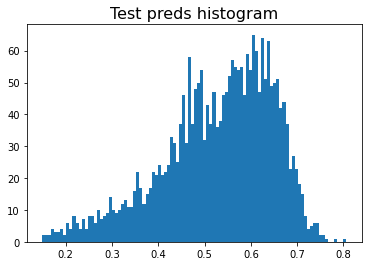

In [41]:
plt.hist(preds,bins=100)
plt.title('Test preds histogram',size=16)
plt.show()

In [47]:
sub = pd.read_csv('./input/novozymes-xgboost/novozymes-enzyme-stability-prediction/sample_submission.csv')
sub.tm = preds
sub.loc[sub.seq_id.isin(deletions),'tm'] = sub.loc[~sub.seq_id.isin(deletions),'tm'].mean()
sub.to_csv(f'submission_xgboost.csv',index=False)
sub.head()

seq_id        tm
0   31390  0.612291
1   31391  0.591754
2   31392  0.527902
3   31393  0.679142
4   31394  0.707065

In [43]:
# 잘 연동되었는지 확인하기
!kaggle -h

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...

optional arguments:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit

commands:
  {competitions,c,datasets,d,kernels,k,config}
                        Use one of:
                        competitions {list, files, download, submit, submissions, leaderboard}
                        datasets {list, files, download, create, version, init, metadata, status}
                        config {view, set, unset}
    competitions (c)    Commands related to Kaggle competitions
    datasets (d)        Commands related to Kaggle datasets
    kernels (k)         Commands related to Kaggle kernels
    config              Configuration settings


In [44]:
import os
os.environ['KAGGLE_USERNAME'] = 'sangminnnn'
os.environ['KAGGLE_KEY'] = '520c3f2aae04edf0a6ce397c15d74fd3'

In [45]:
# 잘 연동되었는지 확인하기
!kaggle -h

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...

optional arguments:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit

commands:
  {competitions,c,datasets,d,kernels,k,config}
                        Use one of:
                        competitions {list, files, download, submit, submissions, leaderboard}
                        datasets {list, files, download, create, version, init, metadata, status}
                        config {view, set, unset}
    competitions (c)    Commands related to Kaggle competitions
    datasets (d)        Commands related to Kaggle datasets
    kernels (k)         Commands related to Kaggle kernels
    config              Configuration settings


In [46]:
# 잘 연동되었는지 확인하기
!kaggle -h

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...

optional arguments:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit

commands:
  {competitions,c,datasets,d,kernels,k,config}
                        Use one of:
                        competitions {list, files, download, submit, submissions, leaderboard}
                        datasets {list, files, download, create, version, init, metadata, status}
                        config {view, set, unset}
    competitions (c)    Commands related to Kaggle competitions
    datasets (d)        Commands related to Kaggle datasets
    kernels (k)         Commands related to Kaggle kernels
    config              Configuration settings
